In [1]:
import pandas as pd
import numpy as np
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
# Import data
from os.path import dirname, join
from pathlib import Path
# ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root 
ROOT_DIR = dirname(os.path.abspath('ARCH7211-SPRING2021')) # This is your Project Root
data_PATH = join(ROOT_DIR[:-16],"data","room_info.csv")  # requires `import os`
print(data_PATH)
# input data
data_raw = pd.read_csv(data_PATH)

c:\Users\milad\Documents\GitHub\arch7211-spring2021\data\room_info.csv


In [3]:
#Cleaning data and feature engineering
exclusion = ["Undefined","UserDefined","Other","Elevated"]
merge = {
    "Sauna": "Bath",
    "Den":"LivingRoom",
    "Alcove":"LivingRoom",
    "Library": "Room",
    "RecreationRoom":"Room",
    "DressingRoom":'Closet',
    "Attic" : "Storage",
    "Office" : "Room",
    "TechnicalRoom":"Utility",
    "DraughtLobby" : "Entry",
    "Hall" : "Entry",
    "Basement" : "Storage"
}

data_raw["type_cleaned"] = data_raw["type"].apply(lambda x: merge.get(x,x))
data_raw["exclude"] = ~data_raw["type"].isin(exclusion)

In [4]:
data_cleaned = data_raw[~data_raw["type"].isin(exclusion)]

In [5]:
data_cleaned.groupby("type_cleaned",as_index=False).count().sort_values("path")

,type_cleaned,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,...,contains_Sink,contains_SpaceForAppliance,contains_Stove,contains_Toilet,contains_TumbleDryer,contains_Urinal,contains_WallCabinet,contains_WashingMachine,contains_WaterTap,exclude
2,CarPort,279,279,279,279,279,279,279,279,279,...,279,279,279,279,279,279,279,279,279,279
6,Garage,414,414,414,414,414,414,414,414,414,...,414,414,414,414,414,414,414,414,414,414
4,Dining,954,954,954,954,954,954,954,954,954,...,954,954,954,954,954,954,954,954,954,954
12,Utility,1489,1489,1489,1489,1489,1489,1489,1489,1489,...,1489,1489,1489,1489,1489,1489,1489,1489,1489,1489
11,Storage,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953
10,Room,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
3,Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
8,LivingRoom,4428,4428,4428,4428,4428,4428,4428,4428,4428,...,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
7,Kitchen,4548,4548,4548,4548,4548,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548
5,Entry,6050,6050,6050,6050,6050,6050,6050,6050,6050,...,6050,6050,6050,6050,6050,6050,6050,6050,6050,6050


In [6]:
# Dividing the raw dataset into three sub categories (tier A,B,C)
# Tiers are: fur = furniture related features, con= space connectivity features, spc = space characteristics features
tier_fur = ['type_cleaned']
tier_spc = []
tier_con = ['type_cleaned']
for col in data_cleaned.columns:
    if 'contains_' in col:
        tier_fur.append(col)
    elif '_to_' in col:
        tier_con.append(col)
    else:
        tier_spc.append(col)
col_select = {
    'tierA' : tier_fur,
    'tierB' : tier_con,
    'tierC' : tier_spc
            } 

In [42]:
#Creating sub-datasets for each tier : tier1) furniture characteristics tier2) fur + connectivity tier 3) whole dataset
data_tier1a = pd.DataFrame(data_cleaned[col_select['tierA']])
data_tier1b = pd.DataFrame(data_cleaned[col_select['tierB']])
data_tier1c = pd.DataFrame(data_cleaned[col_select['tierC']])
data_tier2 = data_tier1c.copy()
data_tier2[col_select['tierB']] = data_tier1b
# quick view of the dataset grouped by type
data_tier2.groupby('type_cleaned').count().sort_values('path', ascending= False)

,path,type,classes,floor_index,num_sides,area,proportion_floor_area,perimeter,compactness,num_adjacent_walls,...,open_to_Storage,door_to_Storage,open_to_TechnicalRoom,door_to_TechnicalRoom,open_to_Undefined,door_to_Undefined,open_to_UserDefined,door_to_UserDefined,open_to_Utility,door_to_Utility
type_cleaned,,,,,,,,,,,,,,,,,,,,,
Bedroom,7993,7993,7993,7993,7993,7993,7993,7993,7993,7993,...,7993,7993,7993,7993,7993,7993,7993,7993,7993,7993
Outdoor,7852,7852,7852,7852,7852,7852,7852,7852,7852,7852,...,7852,7852,7852,7852,7852,7852,7852,7852,7852,7852
Bath,7288,7288,7288,7288,7288,7288,7288,7288,7288,7288,...,7288,7288,7288,7288,7288,7288,7288,7288,7288,7288
Entry,6050,6050,6050,6050,6050,6050,6050,6050,6050,6050,...,6050,6050,6050,6050,6050,6050,6050,6050,6050,6050
Kitchen,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548
LivingRoom,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428,...,4428,4428,4428,4428,4428,4428,4428,4428,4428,4428
Closet,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041,...,3041,3041,3041,3041,3041,3041,3041,3041,3041,3041
Room,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116,...,2116,2116,2116,2116,2116,2116,2116,2116,2116,2116
Storage,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953,...,1953,1953,1953,1953,1953,1953,1953,1953,1953,1953


In [47]:
# Check redundancy of columns in dataframes
def colUniq (dframe):
    temp = []
    for col in dframe.columns:
        if col not in temp:
            temp.append(col)
    return('num cols in df: ',len(dframe.columns),' num unique cols:',len(temp))
colUniq(data_tier2)

('num cols in df: ', 80, ' num unique cols:', 80)

In [8]:
#Defining Train and Target data
X = data_tier1c.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier1c.columns], axis =1)
y = data_tier1c['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3, stratify=y)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.2, stratify=y_train)

In [9]:
#XGB default parameters
xgb = XGBClassifier(objective='multi:softprob',
                    learning_rate = 0.02,
                    n_estimators = 1000,
                    max_depth = 6,
                    subsample= 0.9,
                    colsample_bytree = 0.6,
                    seed = 27)
print(xgb)

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.02, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, seed=27, subsample=0.9,
              tree_method=None, validate_parameters=None, verbosity=None)


In [10]:
xgb.fit(X_train,y_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

lidation_0-mlogloss:0.35007	validation_0-merror:0.11503	validation_1-mlogloss:0.33838	validation_1-merror:0.10757
[837]	validation_0-mlogloss:0.34989	validation_0-merror:0.11496	validation_1-mlogloss:0.33822	validation_1-merror:0.10742
[838]	validation_0-mlogloss:0.34968	validation_0-merror:0.11470	validation_1-mlogloss:0.33803	validation_1-merror:0.10757
[839]	validation_0-mlogloss:0.34947	validation_0-merror:0.11451	validation_1-mlogloss:0.33781	validation_1-merror:0.10742
[840]	validation_0-mlogloss:0.34924	validation_0-merror:0.11448	validation_1-mlogloss:0.33758	validation_1-merror:0.10742
[841]	validation_0-mlogloss:0.34909	validation_0-merror:0.11440	validation_1-mlogloss:0.33745	validation_1-merror:0.10742
[842]	validation_0-mlogloss:0.34890	validation_0-merror:0.11425	validation_1-mlogloss:0.33727	validation_1-merror:0.10742
[843]	validation_0-mlogloss:0.34869	validation_0-merror:0.11418	validation_1-mlogloss:0.33708	validation_1-merror:0.10713
[844]	validation_0-mlogloss:0.34

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=27, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=27, subsample=0.9,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [11]:
evals_result = xgb.evals_result()

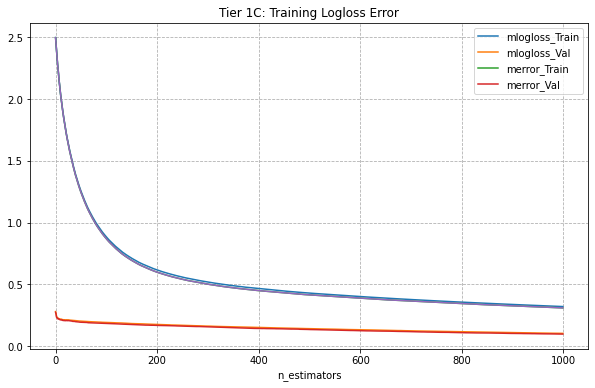

In [12]:
rcParams['figure.figsize'] = 10,6
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier1C_mlogloss.png")  # requires `import os`
plt.plot(evals_result.get('validation_0').get('mlogloss'))   # Train set
plt.plot(evals_result.get('validation_0').get('merror'))
plt.plot(evals_result.get('validation_1').get('mlogloss'))   #Val set
plt.plot(evals_result.get('validation_1').get('merror'))
plt.plot(evals_result.get('validation_1').get('mlogloss'))
plt.title('Tier 1C: Training Logloss Error')
plt.legend(('mlogloss_Train','mlogloss_Val','merror_Train','merror_Val'),loc=1)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.savefig(fig_PATH)
plt.show()

In [13]:
train_score = xgb.score(X_train_train,y_train_train)
print("Tier 1C Training score: ",train_score)

Tier 1C Training score:  0.8957057478049141


In [14]:
best_iteration = xgb.get_booster().best_ntree_limit
y_pred = xgb.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

997


In [15]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 81.19%


In [16]:
report_PATH = join(ROOT_DIR[:-16],"CSV","Tier1C_classificationReport.csv")
class_report = classification_report(y_test,y_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

        Bath       0.79      0.84      0.81      2187
     Bedroom       0.77      0.93      0.84      2398
     CarPort       0.75      0.49      0.59        84
      Closet       0.63      0.63      0.63       912
      Dining       0.77      0.72      0.75       286
       Entry       0.88      0.90      0.89      1815
      Garage       0.72      0.72      0.72       124
     Kitchen       0.86      0.85      0.86      1364
  LivingRoom       0.80      0.86      0.83      1328
     Outdoor       0.95      0.96      0.96      2356
        Room       0.42      0.06      0.10       635
     Storage       0.72      0.68      0.70       586
     Utility       0.61      0.37      0.46       447

    accuracy                           0.81     14522
   macro avg       0.74      0.69      0.70     14522
weighted avg       0.80      0.81      0.80     14522



[[1831   20    0  183    0   63    0   27    2    2    0   16   43]
 [   9 2224    0    3   12    8    4   58   57    6    9    8    0]
 [   0    0   41    0    0    0    5    0    2   33    0    3    0]
 [ 207   11    0  577    5   46    0    2    3    3    0   38   20]
 [   2   19    0    1  206    9    0   13   26    6    1    3    0]
 [  73    9    0   10    7 1641    2   12   22   14    4    6   15]
 [   0    6    2    0    0    0   89    0   14    4    1    8    0]
 [  51   74    0    7   11   11    0 1162   21    0   10    2   15]
 [   4   80    0    6   13   24    3   18 1146    5   22    6    1]
 [   2   23   10    0    1   10    3    1    9 2272    0   25    0]
 [  11  367    2   10    9   19    7   27  125    9   37   10    2]
 [  16   39    0   59    2   19   10    0    7   24    3  400    7]
 [ 115   20    0   61    0   20    1   29    3    2    1   31  164]]


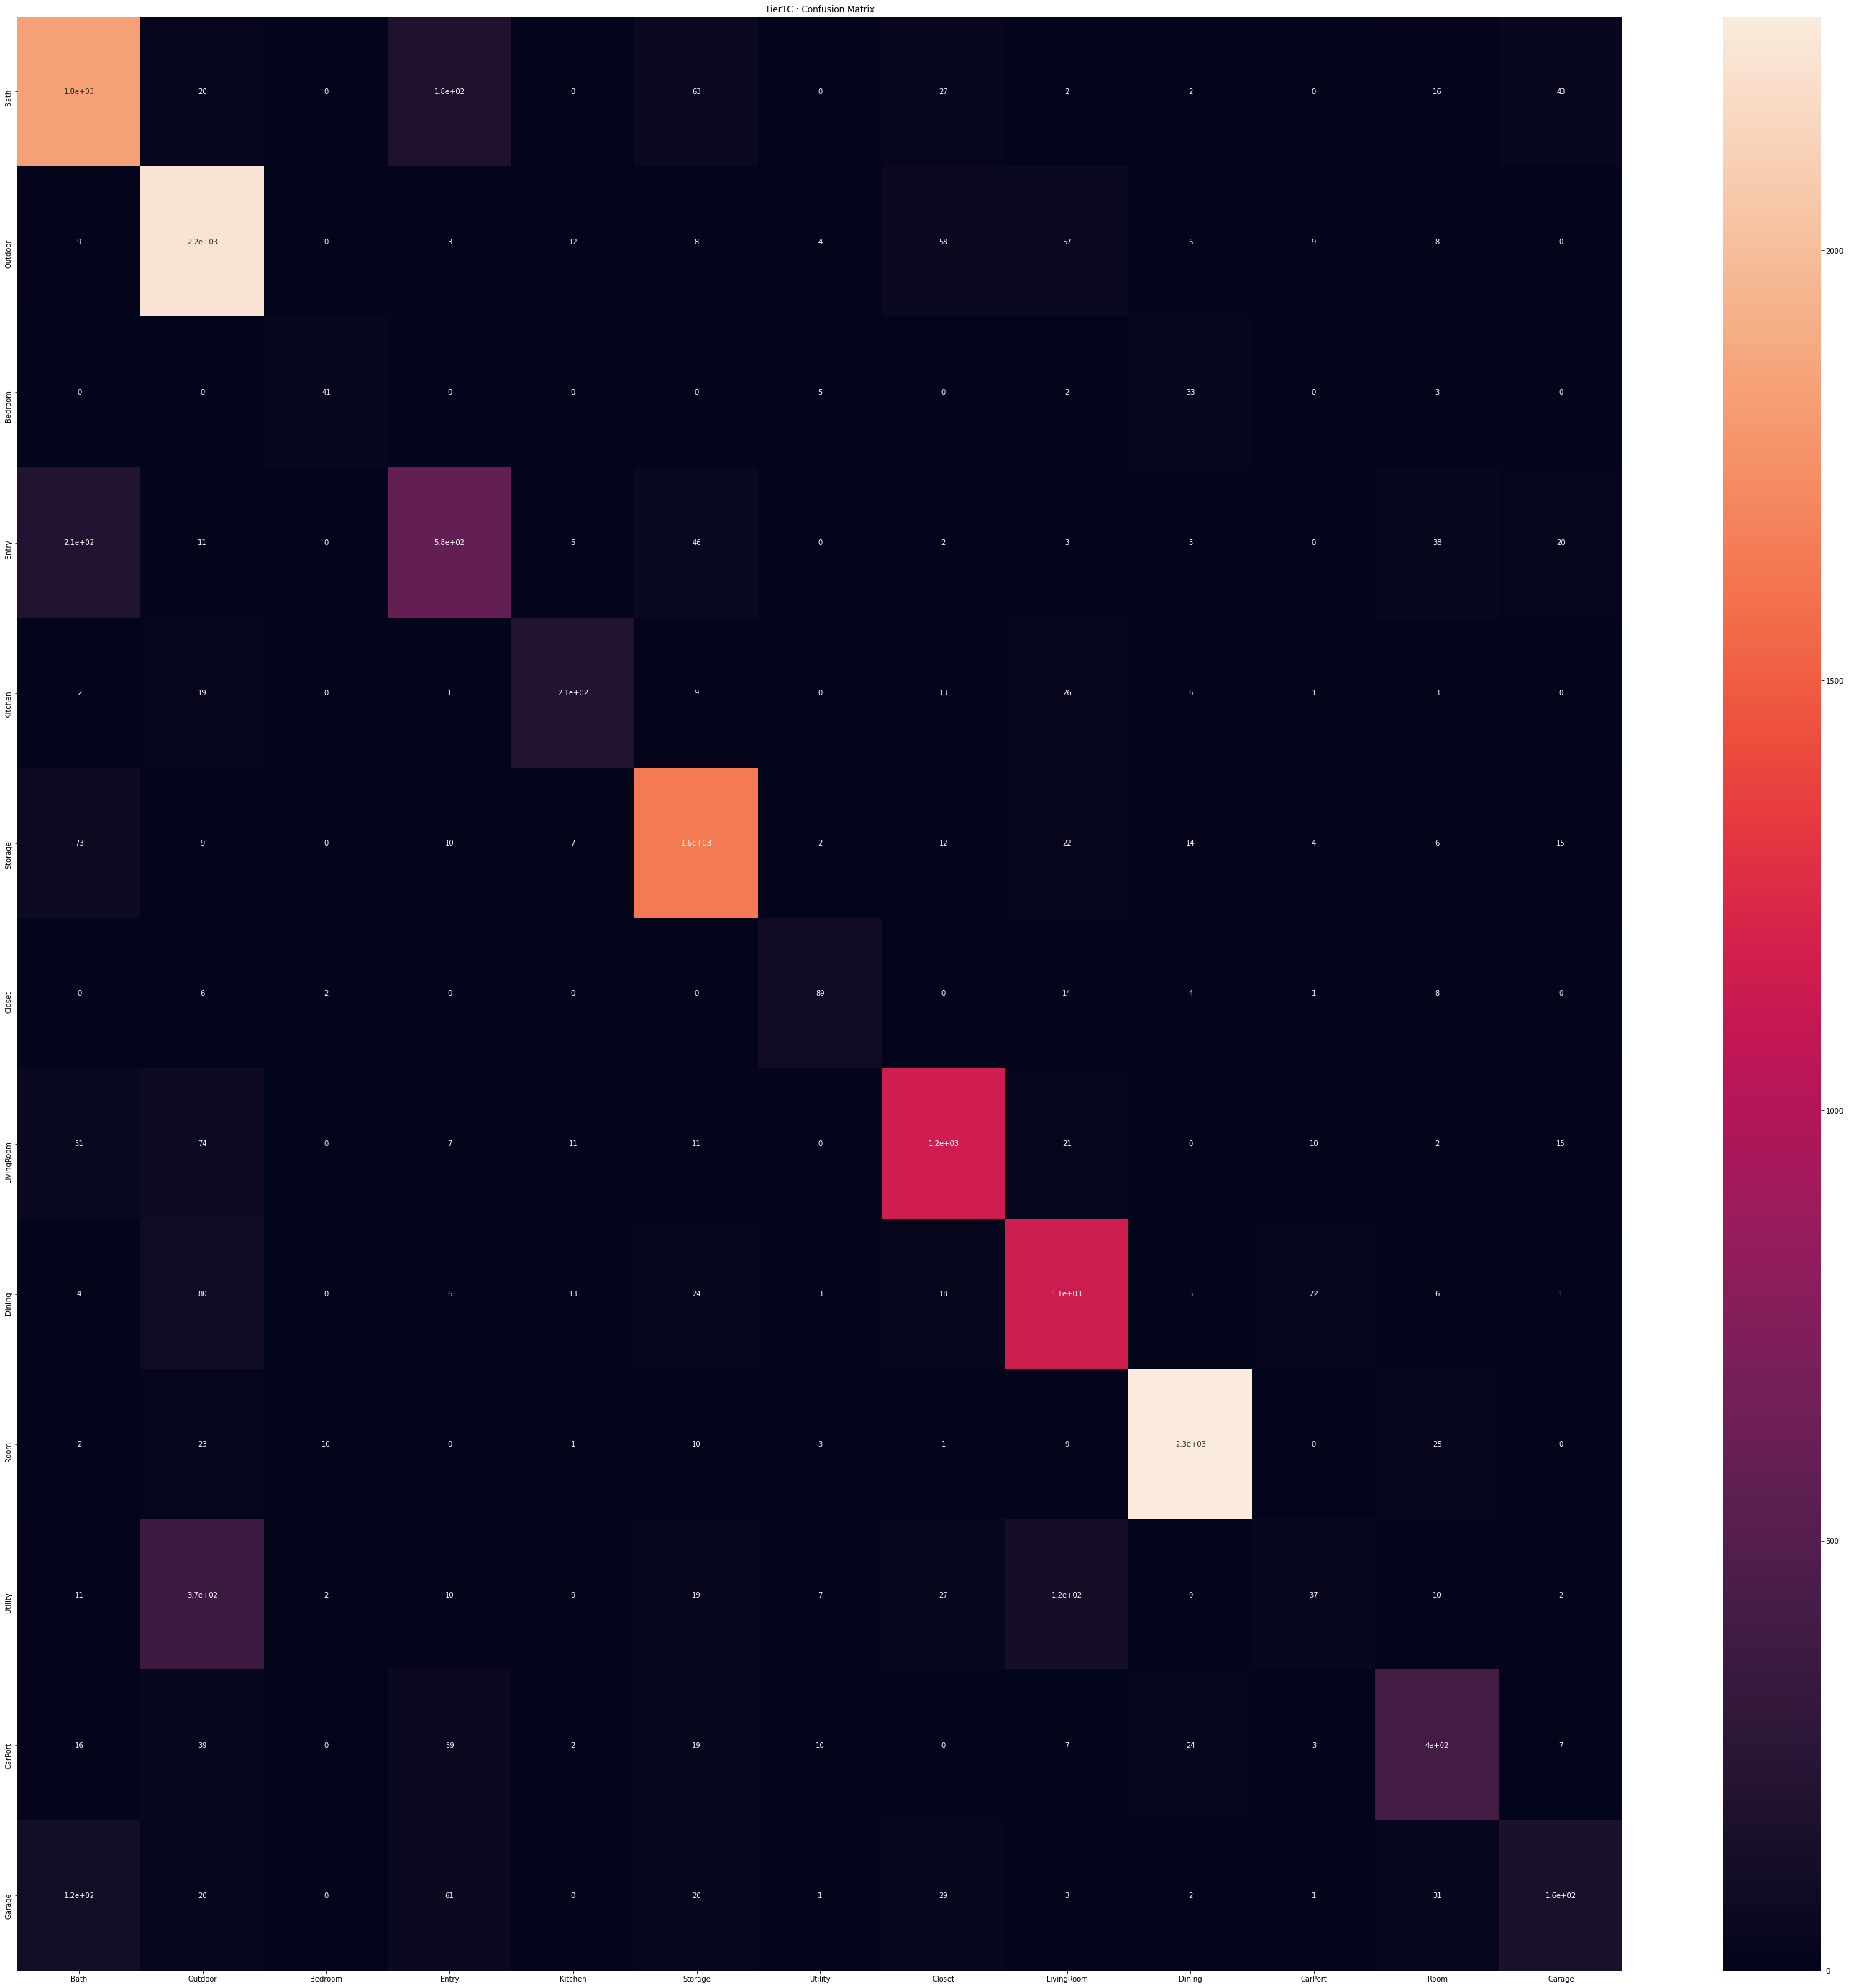

In [17]:
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier1C_ConfMat.png")
cMat = confusion_matrix(y_test,y_pred)
print(cMat)
df_cm = pd.DataFrame(data = cMat , index= pd.Series(y_test).fillna(0).unique() , columns= pd.Series(y_pred).fillna(0).unique())
plt.figure(figsize= (50,50))
sns.heatmap(df_cm, annot=True)
plt.title('Tier1C : Confusion Matrix')
plt.savefig(fig_PATH, dpi=100)
plt.show()

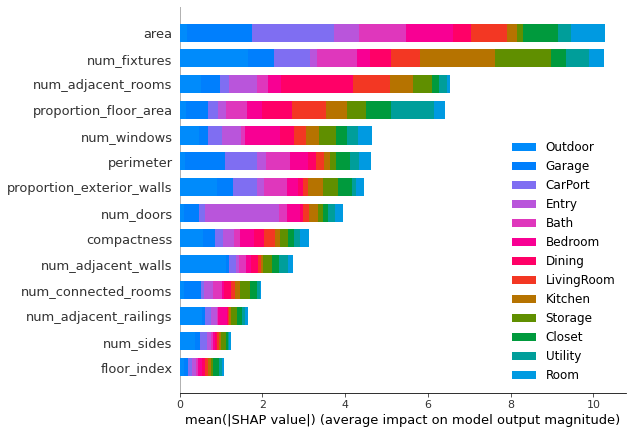

In [19]:
# Feature importance
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier1C_feat_imp.png")
shap_values = shap.TreeExplainer(xgb).shap_values(X_train_train)
f = plt.figure()
shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=xgb.classes_, title='XGBoost Feature Importance')
f.savefig(fig_PATH, bbox_inches='tight', dpi=600)

In [29]:
#Grid Search based on best sub dataset (between tier1a, 1b, and 1c based on their classification reports)

#Grid Search

#Reproductability
seed = 342
np.random.seed(seed)
#Define CV strategy:
cv = StratifiedKFold(n_splits=5 , shuffle=True, random_state=seed)
#params_grid
params_grid = {
    'max_depth' : [5,6,7],
    'subsample': [0.6,0.8,0.9],
    'colsample_bytree' : [0.6,0.8,0.9]
                }
params_fixed = {
    'objective' : 'multi:softprob',
    'n_estimators' : 997,
    'learning_rate' : 0.02
                }
bst_grid = GridSearchCV(estimator=XGBClassifier(**params_fixed, seed=seed),param_grid=params_grid, cv = cv, scoring='f1_macro',return_train_score = True)

In [31]:
fit_params = {
        'eval_set':[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        'eval_metric':['mlogloss','merror'],
        'early_stopping_rounds':50
                }
bst_grid.fit(X_train_train,y_train_train,**fit_params)

lidation_0-mlogloss:0.40512	validation_0-merror:0.13370	validation_1-mlogloss:0.57354	validation_1-merror:0.18371
[483]	validation_0-mlogloss:0.40473	validation_0-merror:0.13340	validation_1-mlogloss:0.57346	validation_1-merror:0.18356
[484]	validation_0-mlogloss:0.40441	validation_0-merror:0.13329	validation_1-mlogloss:0.57343	validation_1-merror:0.18371
[485]	validation_0-mlogloss:0.40409	validation_0-merror:0.13318	validation_1-mlogloss:0.57342	validation_1-merror:0.18386
[486]	validation_0-mlogloss:0.40372	validation_0-merror:0.13300	validation_1-mlogloss:0.57333	validation_1-merror:0.18341
[487]	validation_0-mlogloss:0.40340	validation_0-merror:0.13292	validation_1-mlogloss:0.57328	validation_1-merror:0.18327
[488]	validation_0-mlogloss:0.40298	validation_0-merror:0.13292	validation_1-mlogloss:0.57322	validation_1-merror:0.18341
[489]	validation_0-mlogloss:0.40261	validation_0-merror:0.13285	validation_1-mlogloss:0.57316	validation_1-merror:0.18327
[490]	validation_0-mlogloss:0.40

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=342, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=0.02, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missi...
                                     n_estimators=997, n_jobs=None,
                                     num_parallel_tree=None,
                                     objective='multi:softprob',
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, s

In [34]:
bst_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=997, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [35]:
print('Best params:',bst_grid.best_params_)

Best params: {'colsample_bytree': 0.8, 'max_depth': 6, 'subsample': 0.8}


In [39]:
report_PATH = join(ROOT_DIR[:-16],"CSV","Tier1C_gridsearch.csv")
cv_res_df =pd.DataFrame(bst_grid.cv_results_)
cv_res_df.to_csv(report_PATH)

In [40]:
bst_pred = bst_grid.best_estimator_.predict(X_test)

In [41]:
report_PATH = join(ROOT_DIR[:-16],"CSV","Tier1C_bestparams_classificationReport.csv")
class_report = classification_report(y_test,y_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        Bath       0.79      0.84      0.81      2187
     Bedroom       0.77      0.93      0.84      2398
     CarPort       0.75      0.49      0.59        84
      Closet       0.63      0.63      0.63       912
      Dining       0.77      0.72      0.75       286
       Entry       0.88      0.90      0.89      1815
      Garage       0.72      0.72      0.72       124
     Kitchen       0.86      0.85      0.86      1364
  LivingRoom       0.80      0.86      0.83      1328
     Outdoor       0.95      0.96      0.96      2356
        Room       0.42      0.06      0.10       635
     Storage       0.72      0.68      0.70       586
     Utility       0.61      0.37      0.46       447

    accuracy                           0.81     14522
   macro avg       0.74      0.69      0.70     14522
weighted avg       0.80      0.81      0.80     14522



In [81]:
# TIER 2 -------------------------

#Clean input data from the target data
# define features and predictions
X = data_tier2.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_tier2.columns], axis =1)
y = data_tier2['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.2)

In [82]:
#XGB default parameters
model = bst_grid.best_estimator_
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=997, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [83]:
model.fit(X_train_train,y_train_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

lidation_0-mlogloss:0.30936	validation_0-merror:0.09444	validation_1-mlogloss:0.47415	validation_1-merror:0.14711
[430]	validation_0-mlogloss:0.30905	validation_0-merror:0.09426	validation_1-mlogloss:0.47405	validation_1-merror:0.14711
[431]	validation_0-mlogloss:0.30872	validation_0-merror:0.09426	validation_1-mlogloss:0.47393	validation_1-merror:0.14726
[432]	validation_0-mlogloss:0.30839	validation_0-merror:0.09411	validation_1-mlogloss:0.47379	validation_1-merror:0.14726
[433]	validation_0-mlogloss:0.30803	validation_0-merror:0.09408	validation_1-mlogloss:0.47366	validation_1-merror:0.14711
[434]	validation_0-mlogloss:0.30762	validation_0-merror:0.09400	validation_1-mlogloss:0.47352	validation_1-merror:0.14771
[435]	validation_0-mlogloss:0.30733	validation_0-merror:0.09393	validation_1-mlogloss:0.47337	validation_1-merror:0.14771
[436]	validation_0-mlogloss:0.30697	validation_0-merror:0.09382	validation_1-mlogloss:0.47326	validation_1-merror:0.14741
[437]	validation_0-mlogloss:0.30

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=997, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [84]:
evals_result_tier2 = model.evals_result()

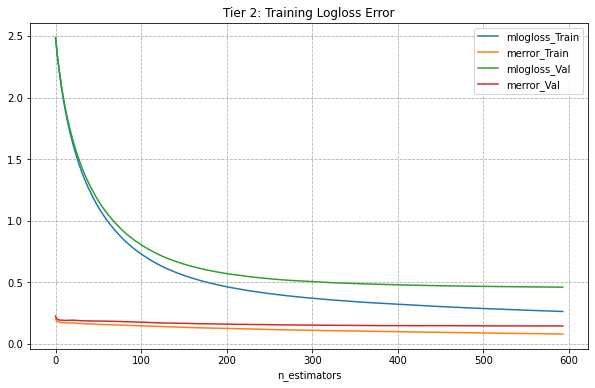

In [85]:

rcParams['figure.figsize'] = 10,6
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier2_mlogloss.png")  # requires `import os`
plt.plot(evals_result_tier2.get('validation_0').get('mlogloss'))   # Train set
plt.plot(evals_result_tier2.get('validation_0').get('merror'))
plt.plot(evals_result_tier2.get('validation_1').get('mlogloss'))   #Val set
plt.plot(evals_result_tier2.get('validation_1').get('merror'))
plt.title('Tier 2: Training Logloss Error')
plt.legend(('mlogloss_Train','merror_Train','mlogloss_Val','merror_Val'),loc=1)
plt.xlabel('n_estimators')
# plt.ylabel('mlogloss')
plt.grid(True, linestyle="--")
plt.savefig(fig_PATH)
plt.show()

In [86]:
train_score = model.score(X_train_train,y_train_train)
print("Tier 2 Training score: ",train_score)

Tier 2 Training score:  0.916254703755626


In [87]:
best_iteration = model.get_booster().best_ntree_limit
y_pred = model.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

544


In [88]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 85.90%


In [89]:
report_PATH = join(ROOT_DIR[:-16],"CSV","Tier2_classificationReport.csv")
class_report = classification_report(y_test,y_pred,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

        Bath       0.87      0.92      0.89      2220
     Bedroom       0.80      0.93      0.86      2413
     CarPort       0.77      0.45      0.57        89
      Closet       0.77      0.72      0.75       908
      Dining       0.87      0.87      0.87       270
       Entry       0.91      0.95      0.93      1785
      Garage       0.81      0.79      0.80       140
     Kitchen       0.89      0.89      0.89      1343
  LivingRoom       0.86      0.89      0.87      1368
     Outdoor       0.96      0.97      0.97      2359
        Room       0.45      0.15      0.22       620
     Storage       0.78      0.74      0.76       555
     Utility       0.74      0.57      0.64       452

    accuracy                           0.86     14522
   macro avg       0.81      0.76      0.77     14522
weighted avg       0.85      0.86      0.85     14522



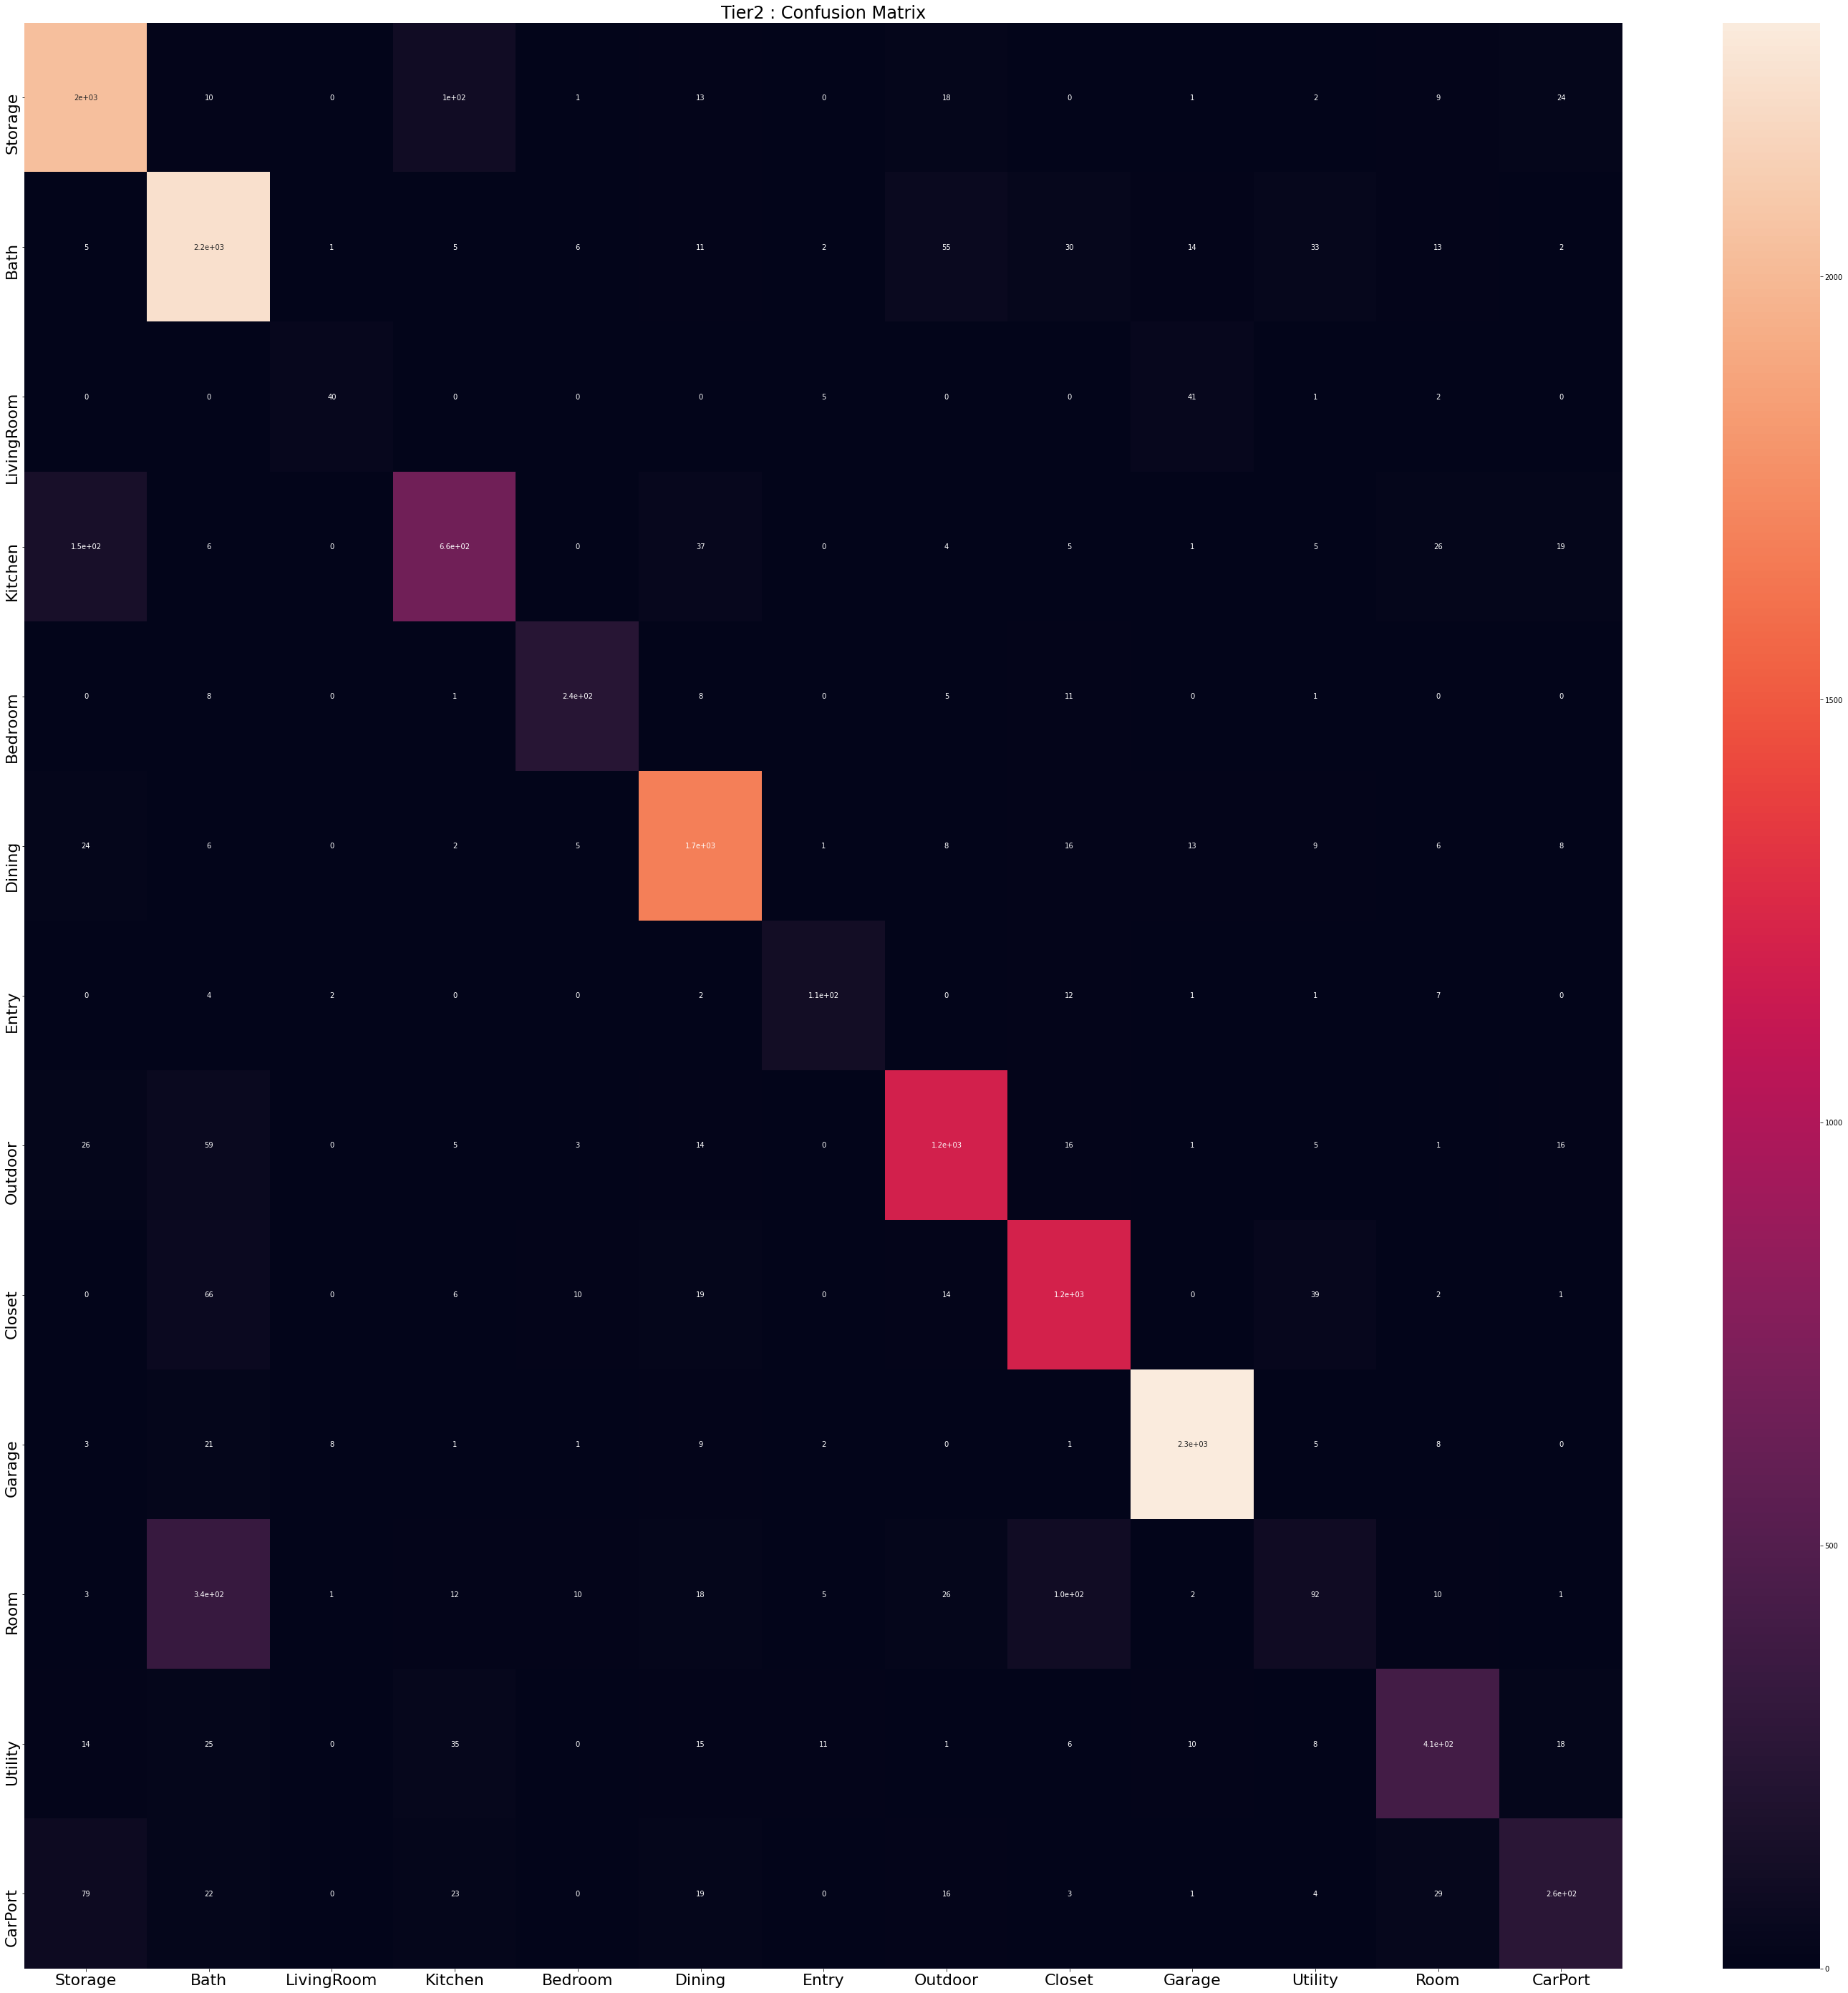

In [91]:
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier2_ConfMat.png")
cMat = confusion_matrix(y_test,y_pred)
df_cm = pd.DataFrame(data = cMat , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred).unique())
# df_cm = pd.DataFrame(data = cMat)
# df_cm.head()
plt.figure(figsize= (50,50))
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
sns.heatmap(df_cm, annot=True)
plt.title('Tier2 : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=100)
plt.show()

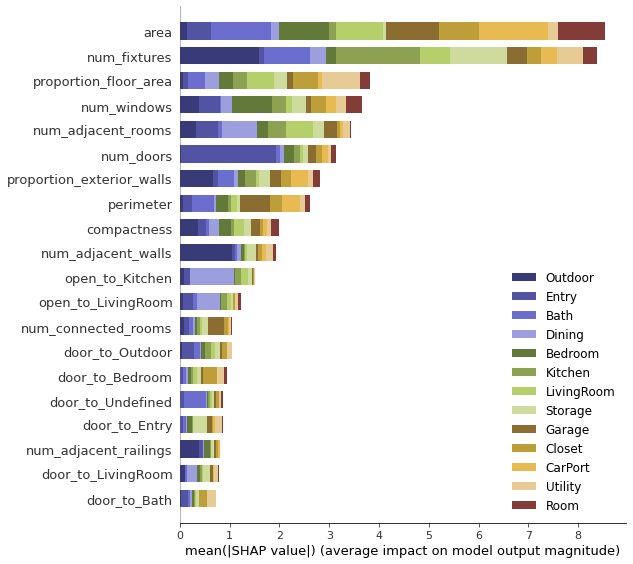

<Figure size 720x432 with 0 Axes>

In [92]:
# Feature importance
shap_values = shap.TreeExplainer(model).shap_values(X_train_train)
shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=model.classes_, title='XGBoost Feature Importance', color = plt.get_cmap("tab20b"))
plt.savefig('Tier 2_featureImp.png',dpi=100)
plt.show()

In [93]:
#Model Final
# TIER 3 -------WHOLE DATA---------

#Clean input data from the target data
# define features and predictions
X = data_cleaned.drop([x for x in['path','type','classes','open_to','door_to','contains','type_cleaned','exclude'] if x in data_cleaned.columns], axis =1)
y = data_cleaned['type_cleaned']
#Split the data into training data, and test data 
X_train , X_test, y_train, y_test = train_test_split(X,y, test_size= 0.3)
X_train_train , X_train_val, y_train_train, y_train_val = train_test_split(X_train,y_train, test_size= 0.2)

#model parameters
model_final = bst_grid.best_estimator_
print(model_final)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=997, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [94]:
model_final.fit(X_train_train,y_train_train,
        eval_set=[(X_train_train, y_train_train), (X_train_val, y_train_val)],
        eval_metric= ['mlogloss','merror'],
        early_stopping_rounds=50,
        verbose=True)

lidation_0-mlogloss:0.24891	validation_0-merror:0.07323	validation_1-mlogloss:0.35777	validation_1-merror:0.10595
[355]	validation_0-mlogloss:0.24849	validation_0-merror:0.07316	validation_1-mlogloss:0.35757	validation_1-merror:0.10580
[356]	validation_0-mlogloss:0.24803	validation_0-merror:0.07301	validation_1-mlogloss:0.35729	validation_1-merror:0.10580
[357]	validation_0-mlogloss:0.24762	validation_0-merror:0.07294	validation_1-mlogloss:0.35711	validation_1-merror:0.10565
[358]	validation_0-mlogloss:0.24722	validation_0-merror:0.07297	validation_1-mlogloss:0.35690	validation_1-merror:0.10565
[359]	validation_0-mlogloss:0.24685	validation_0-merror:0.07290	validation_1-mlogloss:0.35677	validation_1-merror:0.10565
[360]	validation_0-mlogloss:0.24644	validation_0-merror:0.07290	validation_1-mlogloss:0.35660	validation_1-merror:0.10565
[361]	validation_0-mlogloss:0.24603	validation_0-merror:0.07260	validation_1-mlogloss:0.35640	validation_1-merror:0.10550
[362]	validation_0-mlogloss:0.24

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.02, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=997, n_jobs=8, num_parallel_tree=1,
              objective='multi:softprob', random_state=342, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, seed=342, subsample=0.8,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [109]:
evals_result_final = model_final.evals_result()

In [110]:
train_score_final = model_final.score(X_train_train,y_train_train)
print("Tier 3 Training score: ",train_score)

Tier 3 Training score:  0.916254703755626


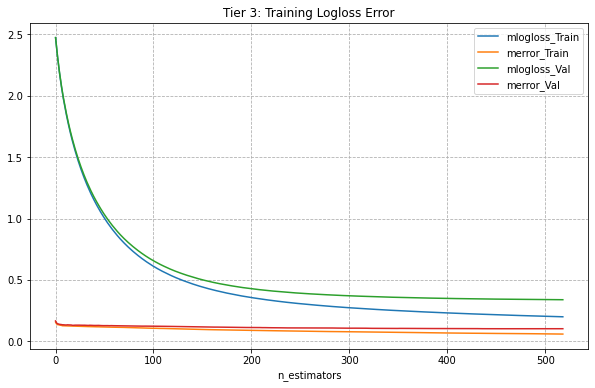

In [112]:
plt.rcParams['font.size'] = 10
rcParams['figure.figsize'] = 10,6
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier3_mlogloss.png")  # requires `import os`
plt.plot(evals_result_final.get('validation_0').get('mlogloss'))   # Train set
plt.plot(evals_result_final.get('validation_0').get('merror'))
plt.plot(evals_result_final.get('validation_1').get('mlogloss'))   #Val set
plt.plot(evals_result_final.get('validation_1').get('merror'))
plt.title('Tier 3: Training Logloss Error')
plt.legend(('mlogloss_Train','merror_Train','mlogloss_Val','merror_Val'),loc=1)
plt.xlabel('n_estimators')
plt.grid(True, linestyle="--")
plt.savefig(fig_PATH)
plt.show()

In [113]:
best_iteration = model_final.get_booster().best_ntree_limit
y_pred_final = model_final.predict(X_test, ntree_limit=best_iteration)
print(best_iteration)

469


In [114]:
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred_final)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 89.38%


In [100]:
report_PATH = join(ROOT_DIR[:-16],"CSV","Tier3_classificationReport.csv")
class_report = classification_report(y_test,y_pred_final,output_dict= True)
report_df = pd.DataFrame(class_report)
report_df.to_csv(report_PATH)
print(classification_report(y_test,y_pred_final))

              precision    recall  f1-score   support

        Bath       0.97      0.96      0.96      2149
     Bedroom       0.83      0.95      0.89      2415
     CarPort       0.88      0.61      0.72        96
      Closet       0.85      0.89      0.87       878
      Dining       0.92      0.90      0.91       293
       Entry       0.94      0.96      0.95      1843
      Garage       0.71      0.76      0.73       115
     Kitchen       0.97      0.96      0.96      1333
  LivingRoom       0.84      0.91      0.87      1313
     Outdoor       0.96      0.98      0.97      2371
        Room       0.43      0.14      0.21       660
     Storage       0.75      0.75      0.75       579
     Utility       0.88      0.73      0.80       477

    accuracy                           0.89     14522
   macro avg       0.84      0.81      0.82     14522
weighted avg       0.88      0.89      0.88     14522



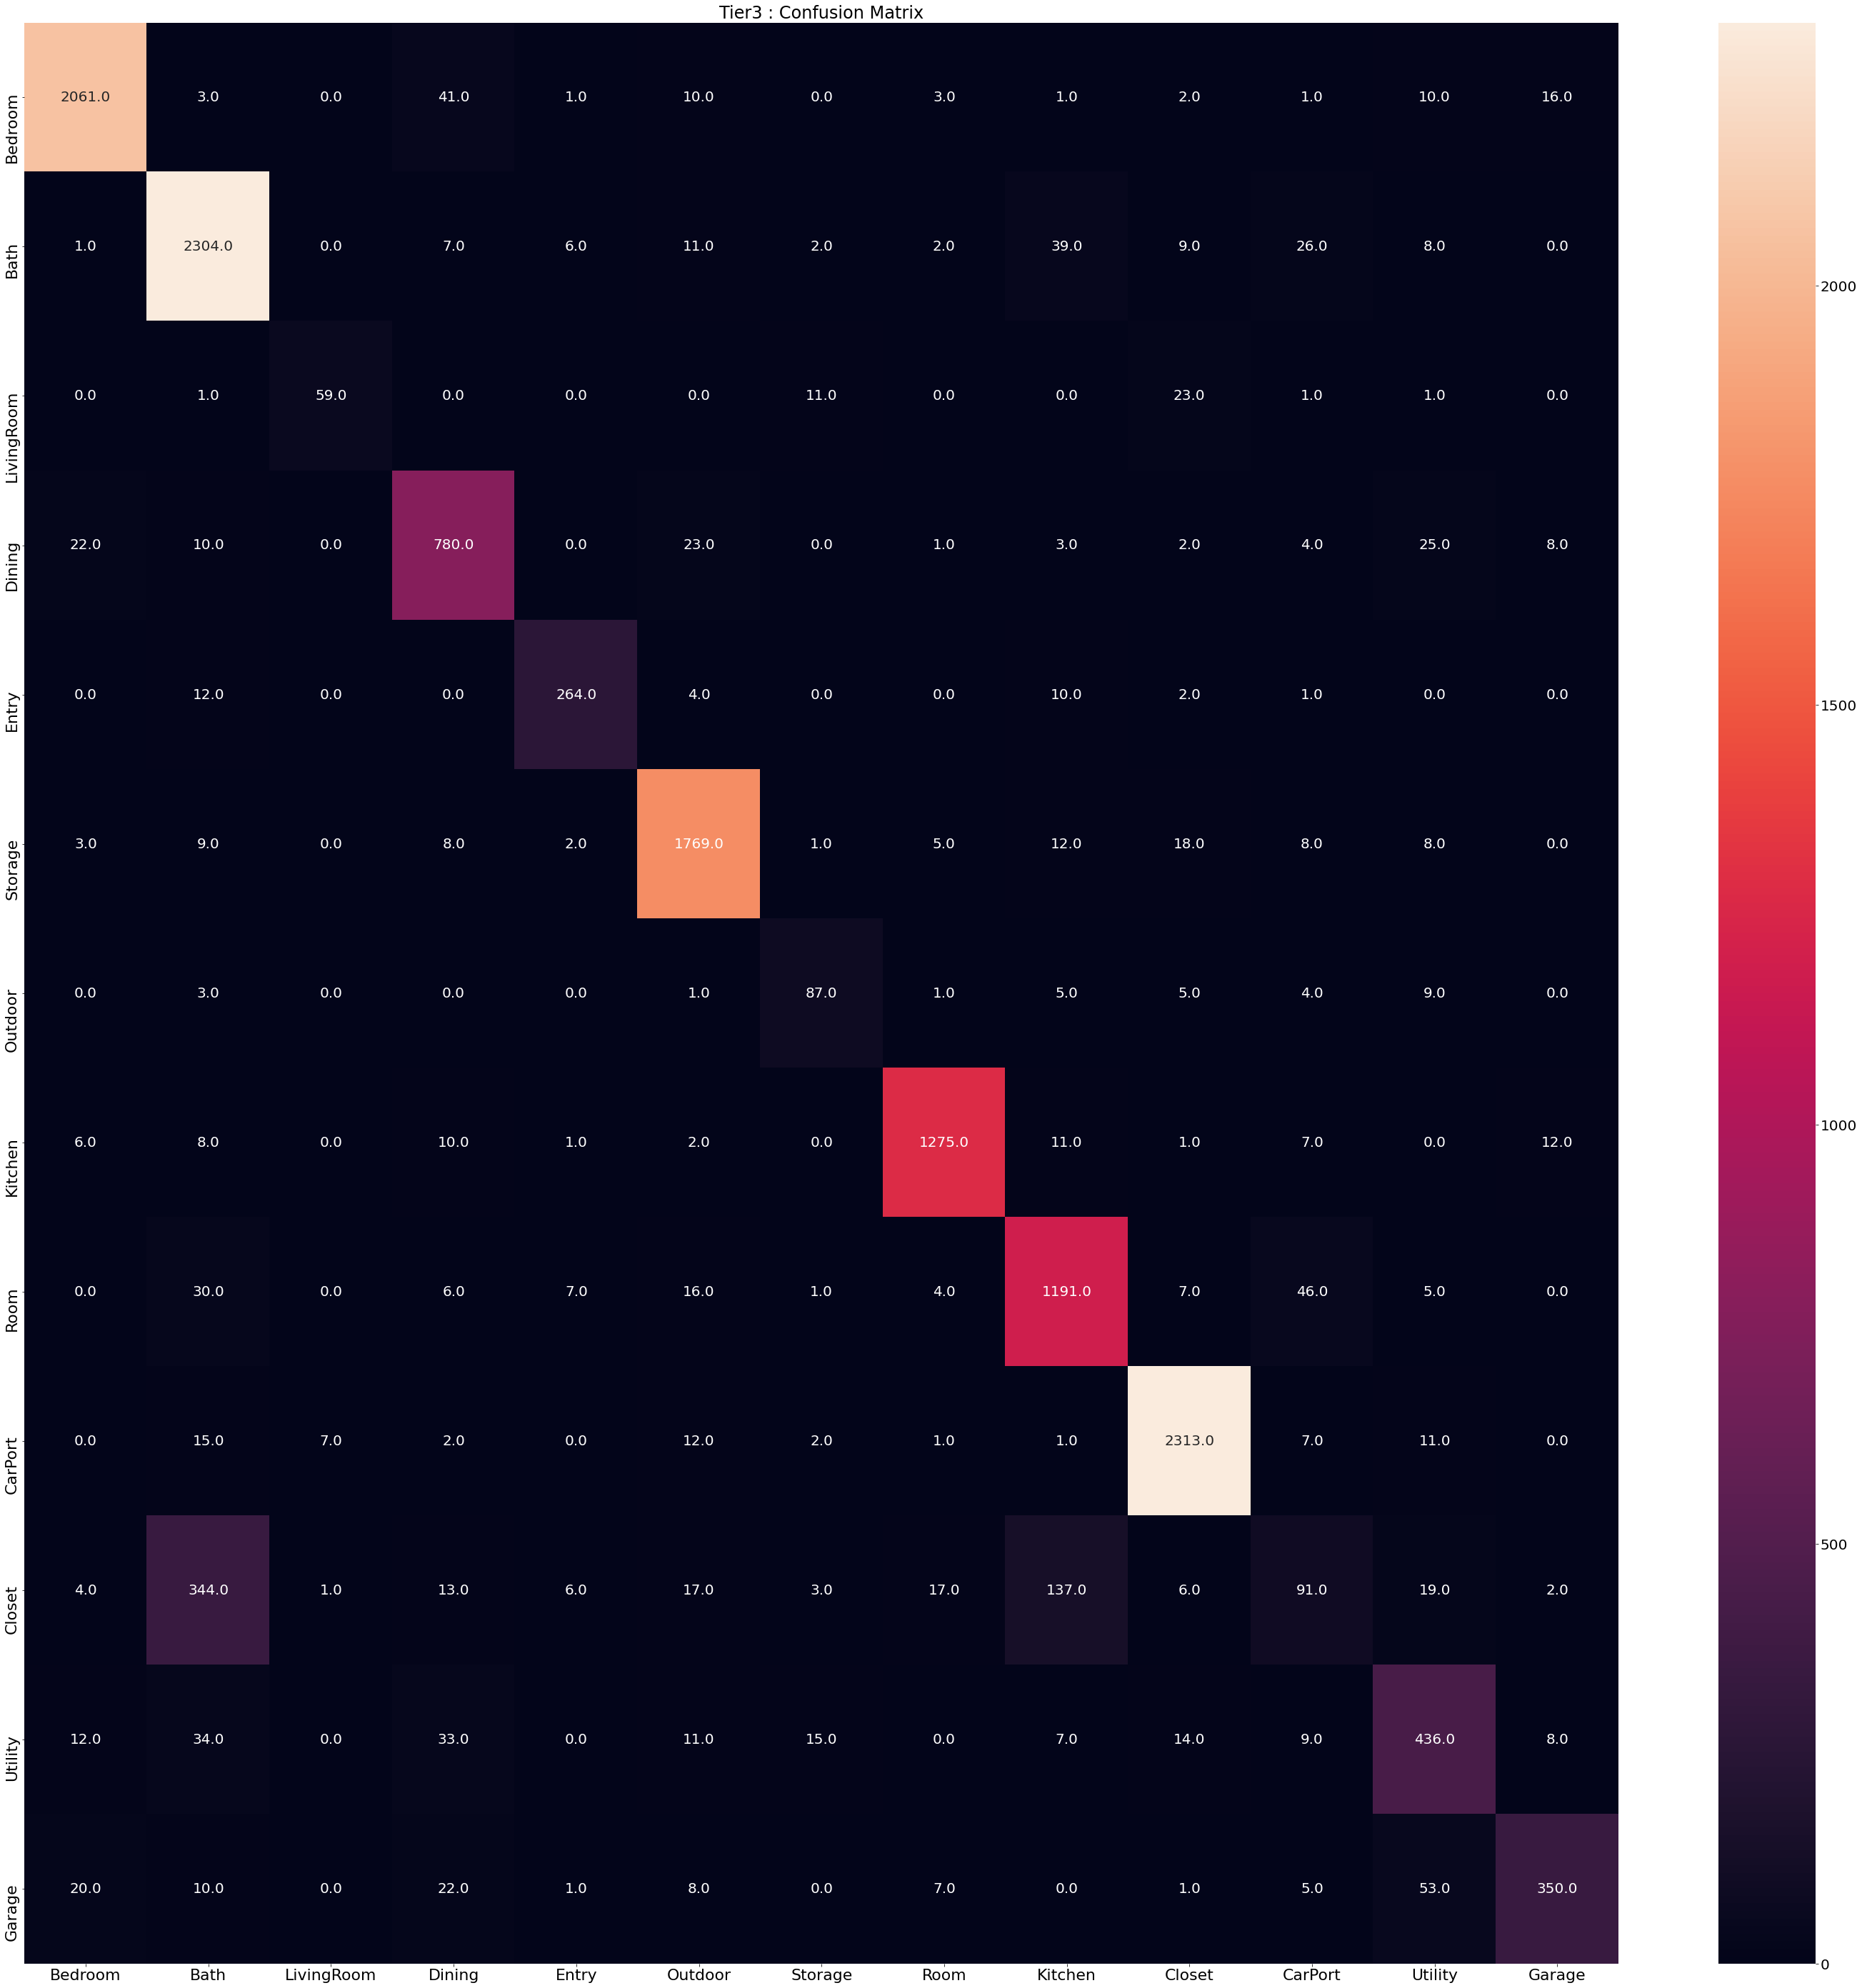

In [106]:
fig_PATH = join(ROOT_DIR[:-16],"Charts_Graphs","Tier3_ConfMat.png")
cMat = confusion_matrix(y_test,y_pred_final)
df_cm = pd.DataFrame(data = cMat , index= pd.Series(y_test).unique() , columns= pd.Series(y_pred_final).unique())
# df_cm = pd.DataFrame(data = cMat)
# df_cm.head()
plt.figure(figsize= (50,50))
plt.rcParams['font.size'] = 20
plt.xticks(fontsize = 22)
plt.yticks(fontsize = 22)
sns.heatmap(df_cm, annot=True, fmt=".1f")
plt.title('Tier3 : Confusion Matrix', fontsize = 24)
plt.savefig(fig_PATH, dpi=100)
plt.show()

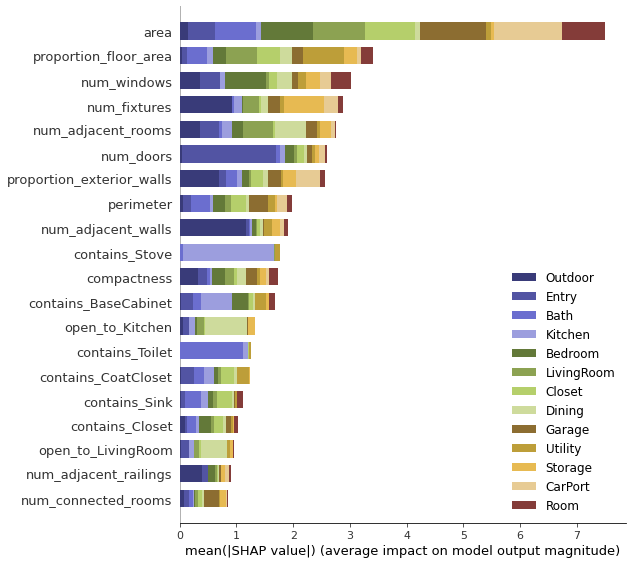

<Figure size 720x432 with 0 Axes>

In [115]:
# Feature importance
shap_values = shap.TreeExplainer(model_final).shap_values(X_train_train)
shap.summary_plot(shap_values, X_train_train, plot_type="bar",class_names=model_final.classes_, title='XGBoost Feature Importance', color = plt.get_cmap("tab20b"))
plt.show()